In [1]:
import warnings; warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

ModuleNotFoundError: No module named 'torch'

In [18]:
df = pd.read_parquet("../data/processed/outlier_removed.parquet")

GENERATE_SPEED_ANGLE = True

weather_cols = [col for col in df.columns if col.startswith(("UGRD", "VGRD"))]

df = df.set_index("forecast_dt")[["rt_plant_id", "production", *weather_cols]]

df = df[df["rt_plant_id"] == 672].drop("rt_plant_id", axis=1)

if GENERATE_SPEED_ANGLE:
    for box in ["SW", "NW", "NE", "SE"]:
        df[f"speed_{box}"] = np.sqrt(np.square(df[f"UGRD_80.m.above.ground.{box}"]) + np.square(df[f"VGRD_80.m.above.ground.{box}"]))
        df[f"angle_{box}"] = np.arctan(df[f"UGRD_80.m.above.ground.{box}"] / df[f"VGRD_80.m.above.ground.{box}"])
 

In [21]:
time_indices = sorted(df.index.unique())
train_ratio = 0.8
valid_ratio = 0.1

train_indices = time_indices[:int(len(time_indices) * train_ratio)]
valid_indices = time_indices[int(len(time_indices) * train_ratio):int(len(time_indices) * (train_ratio + valid_ratio))]
test_indices = time_indices[int(len(time_indices) * (train_ratio + valid_ratio)):]

train_df = df.loc[train_indices, :]
valid_df = df.loc[valid_indices, :]
test_df = df.loc[test_indices, :]

21117

In [24]:
int(len(time_indices) * train_ratio)

21117

In [13]:
window_size = 5

serie_names = [col for col in df.columns if col not in ["production"]]

df = df.sort_index()
X = df[serie_names].values
y = df.production.values

idx = [[j+i for i in range(window_size)] for j in range(0, X.shape[0]-window_size)]
X_sliding = X[idx, :]


In [40]:
df

,production,UGRD_80.m.above.ground.SW,UGRD_80.m.above.ground.NW,UGRD_80.m.above.ground.NE,UGRD_80.m.above.ground.SE,VGRD_80.m.above.ground.SW,VGRD_80.m.above.ground.NW,VGRD_80.m.above.ground.NE,VGRD_80.m.above.ground.SE,speed_SW,angle_SW,speed_NW,angle_NW,speed_NE,angle_NE,speed_SE,angle_SE
forecast_dt,,,,,,,,,,,,,,,,,
2019-01-24 03:00:00,49.00,-4.011990,-3.941990,-2.581990,-3.181990,1.89919,1.99919,0.529194,1.029190,4.438805,-1.128672,4.419960,-1.101443,2.635663,-1.368640,3.344293,-1.257974
2019-01-24 04:00:00,59.00,-4.967610,-4.717610,-3.677610,-4.087610,1.23072,1.31072,0.090718,0.540718,5.117795,-1.327937,4.896308,-1.299796,3.678729,-1.546134,4.123219,-1.439278
2019-01-24 05:00:00,32.00,-4.763300,-4.813300,-3.693300,-4.343300,1.20729,1.03729,0.447295,0.757295,4.913917,-1.322567,4.923802,-1.358538,3.720287,-1.450273,4.408826,-1.398172
2019-01-24 06:00:00,34.00,-4.417460,-4.687460,-3.407460,-4.127460,1.33664,1.45664,0.766641,1.416640,4.615253,-1.276973,4.908572,-1.269504,3.492638,-1.349492,4.363805,-1.240171
2019-01-24 07:00:00,44.00,-4.042970,-4.582970,-3.192970,-3.992970,1.14367,1.56367,0.753667,1.673670,4.201617,-1.295120,4.842383,-1.241990,3.280712,-1.339000,4.329547,-1.173888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-27 19:00:00,0.00,-0.794146,-0.094145,-0.784146,0.995854,1.59903,2.78903,2.049030,2.969030,1.785375,-0.460958,2.790619,-0.033743,2.193948,-0.365497,3.131591,0.323622
2022-01-27 20:00:00,0.13,-0.807156,-0.297156,-1.207160,0.572844,1.71534,2.89534,2.205340,3.425340,1.895756,-0.439813,2.910549,-0.102274,2.514112,-0.500830,3.472910,0.165704
2022-01-27 21:00:00,0.00,-0.550332,-0.110332,-1.300330,0.499668,2.12260,2.94260,2.712600,3.682600,2.192783,-0.253687,2.944668,-0.037477,3.008165,-0.447005,3.716344,0.134860


In [29]:
train_end_idx = train_df.shape[0]
val_end_idx = valid_df.shape[0]

shift_size = 3

In [41]:
X_train = torch.from_numpy(X_sliding[:train_end_idx-shift_size]).float()
y_train = torch.from_numpy(y[shift_size:train_end_idx]).float()
trainset = torch.utils.data.TensorDataset(X_train, y_train)

X_val = torch.from_numpy(X_sliding[train_end_idx-shift_size:train_end_idx+val_end_idx-shift_size]).float()
y_val = torch.from_numpy(y[train_end_idx:train_end_idx+val_end_idx]).float()
valset = torch.utils.data.TensorDataset(X_val, y_val)

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleLSTMModel(nn.Module):
    
    def __init__(self, in_series=16, zdim=32):
        super().__init__()
        
        self.in_series = in_series
        self.zdim = zdim
        self.fc_in = 2*zdim
        fc_outs = [1]
        self.fc_outs = fc_outs
        self.lstm_layer = nn.LSTM(in_series, zdim, bidirectional=True, batch_first=True)
        
        self.fc_list = nn.ModuleList([])
        for i, out_dim in enumerate(self.fc_outs):
            fc_in = fc_outs[i-1] if i > 0 else self.fc_in
            self.fc_list.append(
                nn.Linear(in_features=fc_in, out_features=out_dim)
            )
            
    def forward(self, x):
        
        _, (lstm_out, _) = self.lstm_layer(x)
        
        lstm_out_dir0 = lstm_out[0].view(-1, self.zdim)
        lstm_out_dir1 = lstm_out[1].view(-1, self.zdim)
        x = torch.cat([lstm_out_dir0, lstm_out_dir1], axis=1)
        
        #x = x.view(-1, self.zdim)
        
        for layer in self.fc_list:
            x = layer(x)
            x = F.relu(x)
            
        return x
        

SimpleLSTMModel(
  (lstm_layer): LSTM(16, 32, batch_first=True, bidirectional=True)
  (fc_list): ModuleList(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
)


100%|██████████| 165/165 [00:01<00:00, 136.46it/s]



    Epoch 0: Train Loss: 1973.1591359571978, Val Loss: 1544.5896526518322
                   Train Wmape:  0.9521843791007996,  Val Wmape:  0.8791828155517578


100%|██████████| 165/165 [00:01<00:00, 123.47it/s]



    Epoch 1: Train Loss: 1625.9990007805102, Val Loss: 1259.009753999256
                   Train Wmape:  0.8686073422431946,  Val Wmape:  0.790295422077179


100%|██████████| 165/165 [00:01<00:00, 130.17it/s]



    Epoch 2: Train Loss: 1380.3469993244519, Val Loss: 1068.0050788152785
                   Train Wmape:  0.7993890643119812,  Val Wmape:  0.7147771716117859


100%|██████████| 165/165 [00:01<00:00, 127.19it/s]



    Epoch 3: Train Loss: 1195.6054631551108, Val Loss: 901.8076378958566
                   Train Wmape:  0.7379761338233948,  Val Wmape:  0.645941436290741


100%|██████████| 165/165 [00:01<00:00, 137.54it/s]



    Epoch 4: Train Loss: 1039.0058294007272, Val Loss: 777.6416021074567
                   Train Wmape:  0.6831896901130676,  Val Wmape:  0.5949961543083191


100%|██████████| 165/165 [00:01<00:00, 118.08it/s]



    Epoch 5: Train Loss: 913.2833246520071, Val Loss: 677.2555400303432
                   Train Wmape:  0.6397050619125366,  Val Wmape:  0.5531402230262756


100%|██████████| 165/165 [00:01<00:00, 109.60it/s]



    Epoch 6: Train Loss: 809.8678207975445, Val Loss: 594.9230922517322
                   Train Wmape:  0.6035309433937073,  Val Wmape:  0.5184664726257324


100%|██████████| 165/165 [00:01<00:00, 129.57it/s]



    Epoch 7: Train Loss: 722.5865466840339, Val Loss: 527.4437880743118
                   Train Wmape:  0.5722809433937073,  Val Wmape:  0.4899769425392151


100%|██████████| 165/165 [00:01<00:00, 130.29it/s]



    Epoch 8: Train Loss: 648.6494672601873, Val Loss: 472.4497855050223
                   Train Wmape:  0.5450080633163452,  Val Wmape:  0.4662661552429199


100%|██████████| 165/165 [00:01<00:00, 126.07it/s]



    Epoch 9: Train Loss: 585.5587718616832, Val Loss: 426.5450726463681
                   Train Wmape:  0.5208346843719482,  Val Wmape:  0.4461524486541748


100%|██████████| 165/165 [00:01<00:00, 117.23it/s]



    Epoch 10: Train Loss: 531.1702792543354, Val Loss: 386.31517646426244
                   Train Wmape:  0.4987764060497284,  Val Wmape:  0.4279818832874298


100%|██████████| 165/165 [00:01<00:00, 117.29it/s]



    Epoch 11: Train Loss: 484.18736653183447, Val Loss: 355.14569600423175
                   Train Wmape:  0.4785810708999634,  Val Wmape:  0.4130685329437256


100%|██████████| 165/165 [00:01<00:00, 129.40it/s]



    Epoch 12: Train Loss: 443.70663121541344, Val Loss: 329.3343734741211
                   Train Wmape:  0.4603303372859955,  Val Wmape:  0.4004099369049072


100%|██████████| 165/165 [00:01<00:00, 113.66it/s]



    Epoch 13: Train Loss: 409.01638608990294, Val Loss: 308.9941853114537
                   Train Wmape:  0.44382840394973755,  Val Wmape:  0.3902297019958496


100%|██████████| 165/165 [00:01<00:00, 120.35it/s]



    Epoch 14: Train Loss: 379.3630583560828, Val Loss: 292.26444771176295
                   Train Wmape:  0.42901483178138733,  Val Wmape:  0.38164135813713074


100%|██████████| 165/165 [00:01<00:00, 117.10it/s]



    Epoch 15: Train Loss: 354.1767820878462, Val Loss: 279.39181682041715
                   Train Wmape:  0.41585773229599,  Val Wmape:  0.3744254410266876


100%|██████████| 165/165 [00:01<00:00, 120.72it/s]



    Epoch 16: Train Loss: 332.96581780404756, Val Loss: 269.0089654468355
                   Train Wmape:  0.4042070508003235,  Val Wmape:  0.36832550168037415


100%|██████████| 165/165 [00:01<00:00, 120.62it/s]



    Epoch 17: Train Loss: 314.9661681204131, Val Loss: 260.9095577058338
                   Train Wmape:  0.3937601149082184,  Val Wmape:  0.3633125424385071


100%|██████████| 165/165 [00:01<00:00, 116.90it/s]



    Epoch 18: Train Loss: 299.69627071727405, Val Loss: 254.34947913033622
                   Train Wmape:  0.38431668281555176,  Val Wmape:  0.3591424822807312


100%|██████████| 165/165 [00:01<00:00, 117.91it/s]



    Epoch 19: Train Loss: 286.60106101758555, Val Loss: 249.46138908749535
                   Train Wmape:  0.3757253885269165,  Val Wmape:  0.35573461651802063


100%|██████████| 165/165 [00:01<00:00, 125.74it/s]



    Epoch 20: Train Loss: 275.52580262386437, Val Loss: 245.68587021600632
                   Train Wmape:  0.36803317070007324,  Val Wmape:  0.35252130031585693


100%|██████████| 165/165 [00:01<00:00, 119.36it/s]



    Epoch 21: Train Loss: 266.05618326591724, Val Loss: 242.59186553955078
                   Train Wmape:  0.36105284094810486,  Val Wmape:  0.3495689928531647


100%|██████████| 165/165 [00:01<00:00, 119.18it/s]



    Epoch 22: Train Loss: 257.81646318146676, Val Loss: 240.21084703717912
                   Train Wmape:  0.35460373759269714,  Val Wmape:  0.34692344069480896


100%|██████████| 165/165 [00:01<00:00, 118.70it/s]



    Epoch 23: Train Loss: 250.95672271034934, Val Loss: 238.25814474196662
                   Train Wmape:  0.3488590121269226,  Val Wmape:  0.34444886445999146


100%|██████████| 165/165 [00:01<00:00, 122.50it/s]



    Epoch 24: Train Loss: 245.09430747754647, Val Loss: 236.33890642438615
                   Train Wmape:  0.3435582220554352,  Val Wmape:  0.3423786461353302


100%|██████████| 165/165 [00:01<00:00, 121.36it/s]



    Epoch 25: Train Loss: 239.9957027088512, Val Loss: 235.05119959513345
                   Train Wmape:  0.3387468159198761,  Val Wmape:  0.3408350348472595


100%|██████████| 165/165 [00:01<00:00, 122.03it/s]



    Epoch 26: Train Loss: 235.55905856508198, Val Loss: 233.38963790166946
                   Train Wmape:  0.3342578709125519,  Val Wmape:  0.338981568813324


100%|██████████| 165/165 [00:01<00:00, 116.78it/s]



    Epoch 27: Train Loss: 232.11821731798577, Val Loss: 231.57432628813245
                   Train Wmape:  0.3304766118526459,  Val Wmape:  0.3373976945877075


100%|██████████| 165/165 [00:01<00:00, 119.41it/s]



    Epoch 28: Train Loss: 228.6422275312019, Val Loss: 229.93352054414294
                   Train Wmape:  0.3267473876476288,  Val Wmape:  0.33556798100471497


100%|██████████| 165/165 [00:01<00:00, 118.48it/s]



    Epoch 29: Train Loss: 225.76244949572015, Val Loss: 228.22760373070128
                   Train Wmape:  0.32347026467323303,  Val Wmape:  0.33402019739151


100%|██████████| 165/165 [00:01<00:00, 123.66it/s]



    Epoch 30: Train Loss: 223.24297647187205, Val Loss: 226.99220911661783
                   Train Wmape:  0.32052701711654663,  Val Wmape:  0.33288314938545227


100%|██████████| 165/165 [00:01<00:00, 114.07it/s]



    Epoch 31: Train Loss: 220.83664887168192, Val Loss: 225.31857009161087
                   Train Wmape:  0.3176429569721222,  Val Wmape:  0.33138662576675415


100%|██████████| 165/165 [00:01<00:00, 117.28it/s]



    Epoch 32: Train Loss: 219.02066738244258, Val Loss: 224.8310278029669
                   Train Wmape:  0.31526830792427063,  Val Wmape:  0.3306286931037903


100%|██████████| 165/165 [00:01<00:00, 114.16it/s]



    Epoch 33: Train Loss: 217.20967132105972, Val Loss: 223.40150905790784
                   Train Wmape:  0.3128853142261505,  Val Wmape:  0.32924777269363403


100%|██████████| 165/165 [00:01<00:00, 125.48it/s]



    Epoch 34: Train Loss: 215.85812318975275, Val Loss: 222.57416243780227
                   Train Wmape:  0.3109161853790283,  Val Wmape:  0.32825830578804016


100%|██████████| 165/165 [00:01<00:00, 120.80it/s]



    Epoch 35: Train Loss: 214.5880976821437, Val Loss: 221.470523470924
                   Train Wmape:  0.309074729681015,  Val Wmape:  0.3271496593952179


100%|██████████| 165/165 [00:01<00:00, 116.40it/s]



    Epoch 36: Train Loss: 213.51688723708645, Val Loss: 220.3969357808431
                   Train Wmape:  0.3074408173561096,  Val Wmape:  0.3261301517486572


100%|██████████| 165/165 [00:01<00:00, 120.18it/s]



    Epoch 37: Train Loss: 212.5700206640995, Val Loss: 219.35688073294503
                   Train Wmape:  0.30596673488616943,  Val Wmape:  0.32518282532691956


100%|██████████| 165/165 [00:01<00:00, 118.38it/s]



    Epoch 38: Train Loss: 211.74257192900686, Val Loss: 218.42604519072034
                   Train Wmape:  0.3046508729457855,  Val Wmape:  0.3243498206138611


100%|██████████| 165/165 [00:01<00:00, 112.50it/s]



    Epoch 39: Train Loss: 211.02334094192042, Val Loss: 217.61482275099982
                   Train Wmape:  0.3034789264202118,  Val Wmape:  0.3236294090747833


100%|██████████| 165/165 [00:01<00:00, 123.99it/s]



    Epoch 40: Train Loss: 210.34704483494613, Val Loss: 216.93756521315802
                   Train Wmape:  0.3023792803287506,  Val Wmape:  0.32304647564888


100%|██████████| 165/165 [00:01<00:00, 116.44it/s]



    Epoch 41: Train Loss: 209.67620586048474, Val Loss: 216.39792941865466
                   Train Wmape:  0.3013313412666321,  Val Wmape:  0.3225551247596741


100%|██████████| 165/165 [00:01<00:00, 116.97it/s]



    Epoch 42: Train Loss: 209.02244466145834, Val Loss: 216.0361368088495
                   Train Wmape:  0.30036211013793945,  Val Wmape:  0.322195440530777


100%|██████████| 165/165 [00:01<00:00, 121.54it/s]



    Epoch 43: Train Loss: 208.4504439382842, Val Loss: 215.85989815848214
                   Train Wmape:  0.2995242476463318,  Val Wmape:  0.32209664583206177


100%|██████████| 165/165 [00:01<00:00, 115.91it/s]



    Epoch 44: Train Loss: 207.80678798791135, Val Loss: 215.20575714111328
                   Train Wmape:  0.298682302236557,  Val Wmape:  0.3214980661869049


100%|██████████| 165/165 [00:01<00:00, 115.14it/s]



    Epoch 45: Train Loss: 207.14667262453023, Val Loss: 214.76570347377233
                   Train Wmape:  0.2977128028869629,  Val Wmape:  0.3210985064506531


100%|██████████| 165/165 [00:01<00:00, 119.97it/s]



    Epoch 46: Train Loss: 206.58251323121968, Val Loss: 214.4024418422154
                   Train Wmape:  0.2968892753124237,  Val Wmape:  0.3207462728023529


100%|██████████| 165/165 [00:01<00:00, 121.64it/s]



    Epoch 47: Train Loss: 206.05479218454073, Val Loss: 214.08889461698988
                   Train Wmape:  0.2961343824863434,  Val Wmape:  0.3204520046710968


100%|██████████| 165/165 [00:01<00:00, 120.44it/s]



    Epoch 48: Train Loss: 205.55978568105988, Val Loss: 213.8066793169294
                   Train Wmape:  0.29543983936309814,  Val Wmape:  0.3201891779899597


100%|██████████| 165/165 [00:01<00:00, 119.15it/s]



    Epoch 49: Train Loss: 205.08899888703317, Val Loss: 213.55098942347936
                   Train Wmape:  0.29479458928108215,  Val Wmape:  0.31995272636413574


100%|██████████| 165/165 [00:01<00:00, 119.94it/s]



    Epoch 50: Train Loss: 204.64087675845985, Val Loss: 213.31284495762415
                   Train Wmape:  0.29419463872909546,  Val Wmape:  0.31973814964294434


100%|██████████| 165/165 [00:01<00:00, 115.02it/s]



    Epoch 51: Train Loss: 204.21197487802218, Val Loss: 213.08637437366303
                   Train Wmape:  0.29362013936042786,  Val Wmape:  0.3195301592350006


100%|██████████| 165/165 [00:01<00:00, 120.23it/s]



    Epoch 52: Train Loss: 203.79882472645153, Val Loss: 212.86810829525902
                   Train Wmape:  0.29306933283805847,  Val Wmape:  0.31933730840682983


100%|██████████| 165/165 [00:01<00:00, 118.81it/s]



    Epoch 53: Train Loss: 203.39729966828318, Val Loss: 212.64700063069662
                   Train Wmape:  0.29254183173179626,  Val Wmape:  0.3191317617893219


100%|██████████| 165/165 [00:01<00:00, 115.49it/s]



    Epoch 54: Train Loss: 203.00644630663322, Val Loss: 212.42102777390252
                   Train Wmape:  0.2920418083667755,  Val Wmape:  0.3189350962638855


100%|██████████| 165/165 [00:01<00:00, 117.83it/s]



    Epoch 55: Train Loss: 202.62861819411768, Val Loss: 212.1820905776251
                   Train Wmape:  0.2915654182434082,  Val Wmape:  0.3187285363674164


100%|██████████| 165/165 [00:01<00:00, 122.24it/s]



    Epoch 56: Train Loss: 202.26142059094977, Val Loss: 211.92857106526694
                   Train Wmape:  0.2911135256290436,  Val Wmape:  0.31851229071617126


100%|██████████| 165/165 [00:01<00:00, 117.89it/s]



    Epoch 57: Train Loss: 201.9010911768133, Val Loss: 211.66749845232283
                   Train Wmape:  0.29068848490715027,  Val Wmape:  0.318286269903183


100%|██████████| 165/165 [00:01<00:00, 115.17it/s]



    Epoch 58: Train Loss: 201.5422003659335, Val Loss: 211.39936029343377
                   Train Wmape:  0.2902837097644806,  Val Wmape:  0.31806284189224243


100%|██████████| 165/165 [00:01<00:00, 121.13it/s]



    Epoch 59: Train Loss: 201.1932936697295, Val Loss: 211.1316640944708
                   Train Wmape:  0.2898947298526764,  Val Wmape:  0.3178533613681793


100%|██████████| 165/165 [00:01<00:00, 124.07it/s]



    Epoch 60: Train Loss: 200.84940308079575, Val Loss: 210.86883363269624
                   Train Wmape:  0.2895149886608124,  Val Wmape:  0.31767040491104126


100%|██████████| 165/165 [00:01<00:00, 117.77it/s]



    Epoch 61: Train Loss: 200.50259936939585, Val Loss: 210.61127962384904
                   Train Wmape:  0.28916510939598083,  Val Wmape:  0.317509263753891


100%|██████████| 165/165 [00:01<00:00, 120.26it/s]



    Epoch 62: Train Loss: 200.1591229063092, Val Loss: 210.37793059576126
                   Train Wmape:  0.28881949186325073,  Val Wmape:  0.317350834608078


100%|██████████| 165/165 [00:01<00:00, 120.17it/s]



    Epoch 63: Train Loss: 199.82844642870353, Val Loss: 210.16453152611143
                   Train Wmape:  0.2884690761566162,  Val Wmape:  0.3171786069869995


100%|██████████| 165/165 [00:01<00:00, 126.22it/s]



    Epoch 64: Train Loss: 199.5061566323945, Val Loss: 209.97113454909552
                   Train Wmape:  0.28810954093933105,  Val Wmape:  0.3170143961906433


100%|██████████| 165/165 [00:01<00:00, 114.37it/s]



    Epoch 65: Train Loss: 199.19000832528778, Val Loss: 209.8014030456543
                   Train Wmape:  0.28775036334991455,  Val Wmape:  0.316867858171463


100%|██████████| 165/165 [00:01<00:00, 119.95it/s]



    Epoch 66: Train Loss: 198.8807014696526, Val Loss: 209.65403620402017
                   Train Wmape:  0.2873959243297577,  Val Wmape:  0.31673863530158997


100%|██████████| 165/165 [00:01<00:00, 120.53it/s]



    Epoch 67: Train Loss: 198.57711995442708, Val Loss: 209.51845768519811
                   Train Wmape:  0.28705042600631714,  Val Wmape:  0.316610723733902


100%|██████████| 165/165 [00:01<00:00, 123.31it/s]



    Epoch 68: Train Loss: 198.27812229503286, Val Loss: 209.3902190072196
                   Train Wmape:  0.28671348094940186,  Val Wmape:  0.3164835274219513


100%|██████████| 165/165 [00:01<00:00, 120.15it/s]



    Epoch 69: Train Loss: 197.9834205858635, Val Loss: 209.26963479178292
                   Train Wmape:  0.28639140725135803,  Val Wmape:  0.316368967294693


100%|██████████| 165/165 [00:01<00:00, 121.71it/s]



    Epoch 70: Train Loss: 197.69258073748964, Val Loss: 209.15135156540643
                   Train Wmape:  0.286079078912735,  Val Wmape:  0.3162619173526764


100%|██████████| 165/165 [00:01<00:00, 127.25it/s]



    Epoch 71: Train Loss: 197.4051727294922, Val Loss: 209.03762217930384
                   Train Wmape:  0.2857758700847626,  Val Wmape:  0.3161605894565582


100%|██████████| 165/165 [00:01<00:00, 121.33it/s]



    Epoch 72: Train Loss: 197.1204063762318, Val Loss: 208.9255456470308
                   Train Wmape:  0.2854764759540558,  Val Wmape:  0.3160623610019684


100%|██████████| 165/165 [00:01<00:00, 120.84it/s]



    Epoch 73: Train Loss: 196.83718171553178, Val Loss: 208.8207510085333
                   Train Wmape:  0.2851809561252594,  Val Wmape:  0.3159666657447815


100%|██████████| 165/165 [00:01<00:00, 124.71it/s]



    Epoch 74: Train Loss: 196.53893444176876, Val Loss: 208.92719504946754
                   Train Wmape:  0.2848919630050659,  Val Wmape:  0.316093385219574


100%|██████████| 165/165 [00:01<00:00, 117.67it/s]



    Epoch 75: Train Loss: 196.13614689220083, Val Loss: 209.19793955485025
                   Train Wmape:  0.284684419631958,  Val Wmape:  0.31667691469192505


100%|██████████| 165/165 [00:01<00:00, 121.23it/s]



    Epoch 76: Train Loss: 195.91025632222494, Val Loss: 208.98952175322034
                   Train Wmape:  0.28451764583587646,  Val Wmape:  0.3163681924343109


100%|██████████| 165/165 [00:01<00:00, 113.23it/s]



    Epoch 77: Train Loss: 195.60545828848174, Val Loss: 208.8651731581915
                   Train Wmape:  0.2841624915599823,  Val Wmape:  0.31625300645828247


100%|██████████| 165/165 [00:01<00:00, 116.67it/s]



    Epoch 78: Train Loss: 195.38090108235676, Val Loss: 208.72194653465635
                   Train Wmape:  0.2839549481868744,  Val Wmape:  0.31607118248939514


100%|██████████| 165/165 [00:01<00:00, 118.36it/s]



    Epoch 79: Train Loss: 195.11648885553532, Val Loss: 208.6232555934361
                   Train Wmape:  0.2836275100708008,  Val Wmape:  0.3160409927368164


100%|██████████| 165/165 [00:01<00:00, 119.84it/s]



    Epoch 80: Train Loss: 194.84734515565813, Val Loss: 208.53582654680525
                   Train Wmape:  0.28336817026138306,  Val Wmape:  0.31594276428222656


100%|██████████| 165/165 [00:01<00:00, 124.71it/s]



    Epoch 81: Train Loss: 194.59417279561362, Val Loss: 208.42944608415877
                   Train Wmape:  0.2831198275089264,  Val Wmape:  0.3158251941204071


100%|██████████| 165/165 [00:01<00:00, 125.08it/s]



    Epoch 82: Train Loss: 194.35066442778617, Val Loss: 208.3746277945382
                   Train Wmape:  0.2828681468963623,  Val Wmape:  0.31575965881347656


100%|██████████| 165/165 [00:01<00:00, 119.03it/s]



    Epoch 83: Train Loss: 194.12403219974402, Val Loss: 208.2706456865583
                   Train Wmape:  0.28268614411354065,  Val Wmape:  0.3156089186668396


100%|██████████| 165/165 [00:01<00:00, 125.06it/s]



    Epoch 84: Train Loss: 193.86277943235456, Val Loss: 208.2310182480585
                   Train Wmape:  0.28241944313049316,  Val Wmape:  0.3156006634235382


100%|██████████| 165/165 [00:01<00:00, 118.48it/s]



    Epoch 85: Train Loss: 193.56947367119068, Val Loss: 208.16329956054688
                   Train Wmape:  0.28218182921409607,  Val Wmape:  0.31551918387413025


100%|██████████| 165/165 [00:01<00:00, 124.94it/s]



    Epoch 86: Train Loss: 193.3101667808764, Val Loss: 208.09907804216658
                   Train Wmape:  0.28194156289100647,  Val Wmape:  0.3154083788394928


100%|██████████| 165/165 [00:01<00:00, 122.05it/s]



    Epoch 87: Train Loss: 193.07017792210434, Val Loss: 208.22080557686942
                   Train Wmape:  0.2817454934120178,  Val Wmape:  0.3155975341796875


100%|██████████| 165/165 [00:01<00:00, 118.02it/s]



    Epoch 88: Train Loss: 192.80053635799524, Val Loss: 208.332948412214
                   Train Wmape:  0.2815748155117035,  Val Wmape:  0.31582921743392944


100%|██████████| 165/165 [00:01<00:00, 120.67it/s]



    Epoch 89: Train Loss: 192.50971968679718, Val Loss: 208.4442425682431
                   Train Wmape:  0.28138554096221924,  Val Wmape:  0.31596726179122925


100%|██████████| 165/165 [00:01<00:00, 120.17it/s]



    Epoch 90: Train Loss: 192.24580389080626, Val Loss: 208.44699151175362
                   Train Wmape:  0.2811214029788971,  Val Wmape:  0.3158707022666931


100%|██████████| 165/165 [00:01<00:00, 117.75it/s]



    Epoch 91: Train Loss: 191.98822419137664, Val Loss: 208.50692095075334
                   Train Wmape:  0.28086841106414795,  Val Wmape:  0.3158584237098694


100%|██████████| 165/165 [00:01<00:00, 121.47it/s]



    Epoch 92: Train Loss: 191.71742771033084, Val Loss: 208.5601416088286
                   Train Wmape:  0.28058817982673645,  Val Wmape:  0.31583184003829956


100%|██████████| 165/165 [00:01<00:00, 122.25it/s]



    Epoch 93: Train Loss: 191.4492017919367, Val Loss: 208.61395390828451
                   Train Wmape:  0.2803258001804352,  Val Wmape:  0.3158141076564789


100%|██████████| 165/165 [00:01<00:00, 117.84it/s]



    Epoch 94: Train Loss: 191.18879836111358, Val Loss: 208.6785756065732
                   Train Wmape:  0.28007686138153076,  Val Wmape:  0.31586429476737976


100%|██████████| 165/165 [00:01<00:00, 114.82it/s]



    Epoch 95: Train Loss: 190.93686311895198, Val Loss: 208.75411188034784
                   Train Wmape:  0.27983349561691284,  Val Wmape:  0.31588393449783325


100%|██████████| 165/165 [00:01<00:00, 120.96it/s]


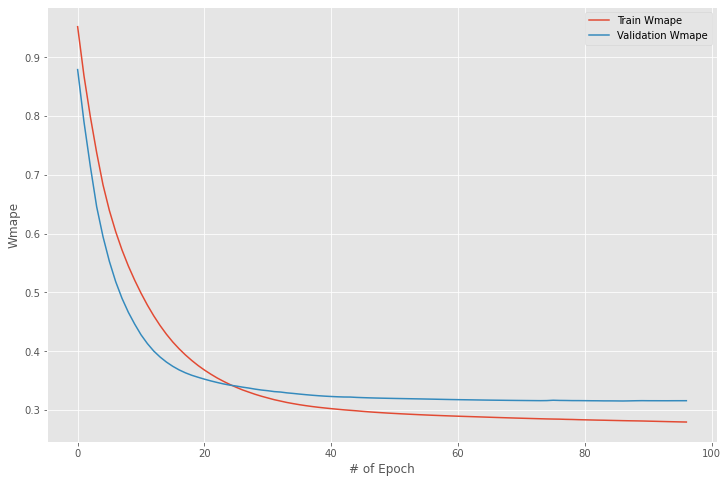

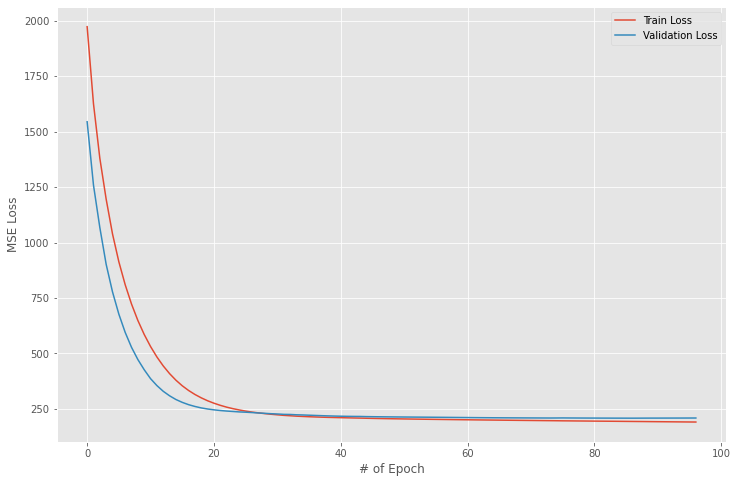

Best Acc:  tensor(0.3154)


In [44]:
import os

import torch
import torch.nn as nn
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import numpy as np

MAX_EPOCH = 100
early_stop_steps = 10
batch_size=128
lr = 5e-4

wd = 3e-4 # For adam

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=10)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=10)

model = SimpleLSTMModel()
model.to(device)
print(model)
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=wd)



train_losses=[]
train_wmapes=[]
val_losses=[]
val_wmapes=[]
best_val_wmape = 100
early_stop_count = 0
for epoch in range(MAX_EPOCH):
    train_loss = 0
    train_abs_dev = 0
    train_prod = 0
    for instance, prod in tqdm(trainloader):
        instance = instance.to(device)
        prod = prod.to(device)
        out = model(instance)
        out = out.flatten()
        loss = loss_fn(out, prod)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_abs_dev += torch.sum(torch.abs(out-prod))
        train_prod += torch.sum(prod)
        

    val_loss = 0
    val_abs_dev = 0
    val_prods = 0
    with torch.no_grad():
        for val_instance, val_prod in valloader:
            val_instance = val_instance.to(device)
            val_prod = val_prod.to(device)
            val_out = model(val_instance)
            val_out = val_out.flatten()
            loss = loss_fn(val_out, val_prod)

            val_loss += loss.item()
            val_abs_dev += torch.sum(torch.abs(val_out-val_prod))
            val_prods += torch.sum(val_prod)

    train_loss = train_loss/(len(trainloader))
    train_wmape = train_abs_dev/train_prod
    train_losses.append(train_loss)
    train_wmapes.append(train_wmape.detach().cpu())

    val_loss = val_loss/(len(valloader))
    val_wmape = val_abs_dev/val_prods
    val_losses.append(val_loss)
    val_wmapes.append(val_wmape.detach().cpu())

    if val_wmape < best_val_wmape:
        early_stop_count=0
        best_val_wmape = val_wmape
        torch.save(model.state_dict(), "./best_model.pkl")
    else:
        early_stop_count+=1

    if early_stop_count >= early_stop_steps:
        break

    print(f"""
    Epoch {epoch}: Train Loss: {train_loss}, Val Loss: {val_loss}
                   Train Wmape:  {train_wmape},  Val Wmape:  {val_wmape}""")

    
plt.style.use("ggplot")
plt.figure(figsize=(12,8))
plt.plot(list(range(len(train_wmapes))), train_wmapes, label='Train Wmape')
plt.plot(list(range(len(val_wmapes))), val_wmapes, label='Validation Wmape')
plt.xlabel("# of Epoch")
plt.ylabel("Wmape")
plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(list(range(len(train_losses))), train_losses, label='Train Loss')
plt.plot(list(range(len(val_losses))), val_losses, label='Validation Loss')
plt.xlabel("# of Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

print("Best Acc: ", best_val_wmape)

In [45]:
X_test = torch.from_numpy(X_sliding[train_end_idx+val_end_idx-window_size:]).float()
y_test= torch.from_numpy(y[train_end_idx+val_end_idx:]).float()
testset = torch.utils.data.TensorDataset(X_test, y_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=X_test.shape[0], shuffle=False, num_workers=10)

with torch.no_grad():
    for test_instance, test_prod in testloader:
        test_instance = test_instance.to(device)
        test_prod = test_prod.to(device)
        test_out = model(test_instance)
        test_out = test_out.flatten()
        loss = loss_fn(test_out, test_prod)

        print(f"TEST L2 LOSS: {loss}")
        test_abs_dev = torch.sum(torch.abs(test_out-test_prod))
        test_prods = torch.sum(test_prod)

        print(f"TEST WMAPE: {test_abs_dev/test_prods}")

TEST L2 LOSS: 305.60205078125
TEST WMAPE: 0.29733362793922424


DatetimeIndex(['2021-10-10 00:00:00', '2021-10-10 01:00:00',
               '2021-10-10 02:00:00', '2021-10-10 03:00:00',
               '2021-10-10 04:00:00', '2021-10-10 05:00:00',
               '2021-10-10 06:00:00', '2021-10-10 07:00:00',
               '2021-10-10 08:00:00', '2021-10-10 09:00:00',
               ...
               '2022-01-27 14:00:00', '2022-01-27 15:00:00',
               '2022-01-27 16:00:00', '2022-01-27 17:00:00',
               '2022-01-27 18:00:00', '2022-01-27 19:00:00',
               '2022-01-27 20:00:00', '2022-01-27 21:00:00',
               '2022-01-27 22:00:00', '2022-01-27 23:00:00'],
              dtype='datetime64[ns]', name='forecast_dt', length=2640, freq=None)

In [57]:
output = df.iloc[train_end_idx+val_end_idx:].reset_index()[["forecast_dt"]]
output["prediction"] = test_out.detach().cpu().numpy()
output["actual"] = test_prod.detach().cpu().numpy()
output = output.set_index("forecast_dt")

<AxesSubplot:xlabel='forecast_dt'>

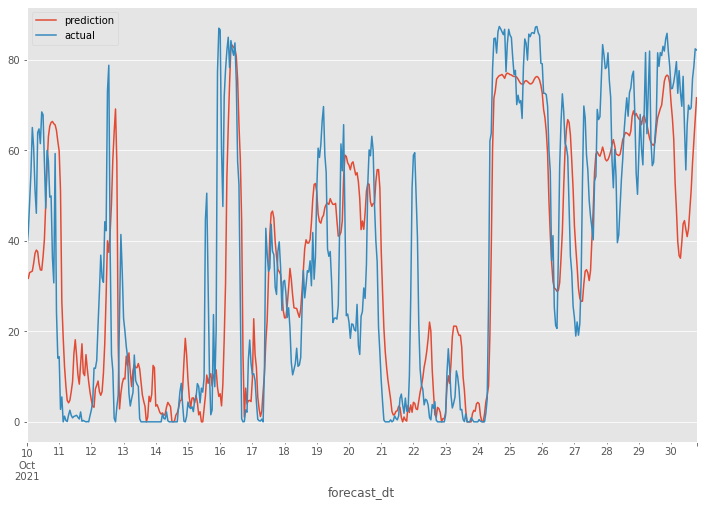

In [59]:
output.iloc[:500].plot(figsize=(12,8))